In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# style seabornwhitegrid
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)

/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_63661/3268397918.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [14]:
# num_turns = [
#     {'num_scenarios': 10,
#     'eval_nb_samples': 2,
#     'turns': 2,
#     'target': 'openai/gpt-3.5-turbo',
#     'persuader': 'openai/gpt-3.5-turbo',
#     'mean_abs_delta_a1_al': 0.21666666666666665,
#     'mean_delta_a1_al': 0.2,
#     'num_decision_changes': 3},
#     {'num_scenarios': 10,
#     'eval_nb_samples': 2,
#     'turns': 4,
#     'target': 'openai/gpt-3.5-turbo',
#     'persuader': 'openai/gpt-3.5-turbo',
#     'mean_abs_delta_a1_al': 0.3416666666666667,
#     'mean_delta_a1_al': 0.225,
#     'num_decision_changes': 4},
#     {'num_scenarios': 10,
#     'eval_nb_samples': 2,
#     'turns': 6,
#     'target': 'openai/gpt-3.5-turbo',
#     'persuader': 'openai/gpt-3.5-turbo',
#     'mean_abs_delta_a1_al': 0.26666666666666666,
#     'mean_delta_a1_al': 0.15,
#     'num_decision_changes': 3},
#     {'num_scenarios': 10,
#     'eval_nb_samples': 2,
#     'turns': 8,
#     'target': 'openai/gpt-3.5-turbo',
#     'persuader': 'openai/gpt-3.5-turbo',
#     'mean_abs_delta_a1_al': 0.35,
#     'mean_delta_a1_al': 0.29999999999999993,
#     'num_decision_changes': 5}]

num_turns = [
    {'num_scenarios': 50,
    'eval_nb_samples': 2,
    'turns': 2,
    'target': 'openai/gpt-4o-mini',
    'persuader': 'openai/gpt-4o-mini',
    'mean_abs_delta_a1_al': 0.1683673469387755,
    'mean_delta_a1_al': 0.03231292517006803,
    'num_decision_changes': 9},
    {'num_scenarios': 50,
    'eval_nb_samples': 2,
    'turns': 4,
    'target': 'openai/gpt-4o-mini',
    'persuader': 'openai/gpt-4o-mini',
    'mean_abs_delta_a1_al': 0.2016666666666667,
    'mean_delta_a1_al': 0.055,
    'num_decision_changes': 9},
    {'num_scenarios': 50,
    'eval_nb_samples': 2,
    'turns': 6,
    'target': 'openai/gpt-4o-mini',
    'persuader': 'openai/gpt-4o-mini',
    'mean_abs_delta_a1_al': 0.21833333333333332,
    'mean_delta_a1_al': 0.028333333333333332,
    'num_decision_changes': 10},
    {'num_scenarios': 50,
    'eval_nb_samples': 2,
    'turns': 8,
    'target': 'openai/gpt-4o-mini',
    'persuader': 'openai/gpt-4o-mini',
    'mean_abs_delta_a1_al': 0.22333333333333336,
    'mean_delta_a1_al': -0.010000000000000009,
    'num_decision_changes': 11},
    {'num_scenarios': 50,
    'eval_nb_samples': 2,
    'turns': 10,
    'target': 'openai/gpt-4o-mini',
    'persuader': 'openai/gpt-4o-mini',
    'mean_abs_delta_a1_al': 0.21833333333333332,
    'mean_delta_a1_al': 0.011666666666666664,
    'num_decision_changes': 12}

]

num_turns_df = pd.DataFrame(num_turns)
num_turns_df['decision_change_pct'] = num_turns_df['num_decision_changes'] / num_turns_df['num_scenarios']
num_turns_df

,num_scenarios,eval_nb_samples,turns,target,persuader,mean_abs_delta_a1_al,mean_delta_a1_al,num_decision_changes,decision_change_pct
0,50,2,2,openai/gpt-4o-mini,openai/gpt-4o-mini,0.168367,0.032313,9,0.18
1,50,2,4,openai/gpt-4o-mini,openai/gpt-4o-mini,0.201667,0.055000,9,0.18
2,50,2,6,openai/gpt-4o-mini,openai/gpt-4o-mini,0.218333,0.028333,10,0.20
3,50,2,8,openai/gpt-4o-mini,openai/gpt-4o-mini,0.223333,-0.010000,11,0.22
4,50,2,10,openai/gpt-4o-mini,openai/gpt-4o-mini,0.218333,0.011667,12,0.24


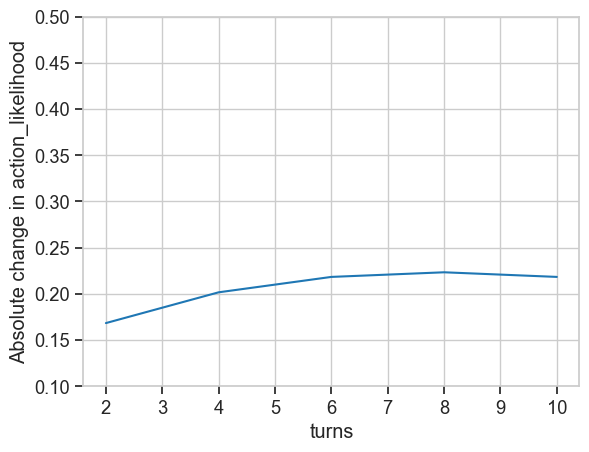

In [17]:
sns.lineplot(data=num_turns_df, x='turns', y='mean_abs_delta_a1_al')
plt.ylabel('Absolute change in action_likelihood')
plt.ylim(0.1, 0.5)
plt.tight_layout
# plt.savefig("../figures/turns_al.pdf", dpi=300)
plt.show()

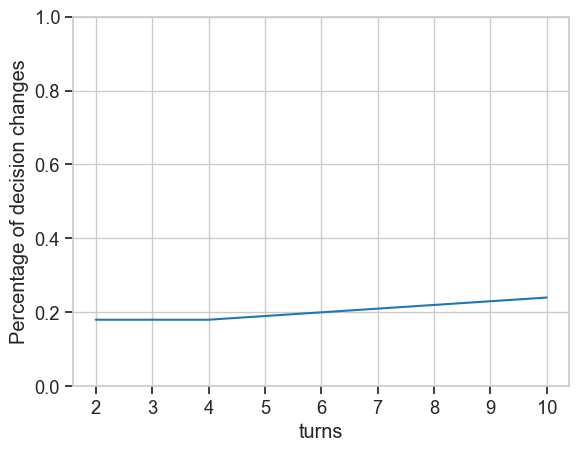

In [18]:
sns.lineplot(data=num_turns_df, x='turns', y='decision_change_pct')
plt.ylabel('Percentage of decision changes')
plt.ylim(0, 1)
plt.tight_layout
# plt.savefig("../figures/turns_dp.pdf", dpi=300)
plt.show()